In [ ]:
!pip install -q catboost shap

In [ ]:
import numpy as np
import pandas as pd

import catboost
import shap
import sklearn.model_selection

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Загрузка данных

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/House Prices Data/train.csv', index_col=0)

test_X = pd.read_csv('/content/drive/MyDrive/House Prices Data/test.csv', index_col=0)

df.head()

MSSubClass MSZoning  LotFrontage  ...  SaleType SaleCondition SalePrice
Id                                    ...                                  
1           60       RL         65.0  ...        WD        Normal    208500
2           20       RL         80.0  ...        WD        Normal    181500
3           60       RL         68.0  ...        WD        Normal    223500
4           70       RL         60.0  ...        WD       Abnorml    140000
5           60       RL         84.0  ...        WD        Normal    250000

[5 rows x 80 columns]

# Удаление / imputting пустых значений

In [ ]:
columns_with_na = df.columns[df.isnull().any()].to_list()
columns_with_na

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [ ]:
df.MasVnrType.isnull().sum() #8 and Area(maybe delete)
df.Electrical.isnull().sum() #1 delete
df.LotFrontage.isnull().sum() #259 do sth
df.BsmtFinType2.isnull().sum() #37 replace with None(but checkout the 38th of FinType2 & Exposure, maybe delete them)
df.FireplaceQu.isnull().sum() #690 replace with None
df.GarageCond.isnull().sum() #81 replace with None all Garage features except YrBuilt, check it out
df.PoolQC.isnull().sum() #1453 replace with None
df.Fence.isnull().sum() #1179 replace with None
df.MiscFeature.isnull().sum() #1406 replace with None
df.Alley.isnull().sum() #1369 replace with None

1369

In [ ]:
train_df = df.dropna(subset=['MasVnrType', 'MasVnrArea', 'Electrical'])
mode4LotFrontage = train_df['LotFrontage'].mode()
mode4YrBuilt = train_df['GarageYrBlt'].mode()
train_df = train_df.fillna(value  = {'LotFrontage': mode4LotFrontage[0]})
train_df.GarageYrBlt = (df.YearBuilt + df.YearRemodAdd // 2)
train_df.fillna(value = 'None', inplace=True)
train_df.head()

MSSubClass MSZoning  LotFrontage  ...  SaleType SaleCondition SalePrice
Id                                    ...                                  
1           60       RL         65.0  ...        WD        Normal    208500
2           20       RL         80.0  ...        WD        Normal    181500
3           60       RL         68.0  ...        WD        Normal    223500
4           70       RL         60.0  ...        WD       Abnorml    140000
5           60       RL         84.0  ...        WD        Normal    250000

[5 rows x 80 columns]

# Подготовка тестового датасета

In [ ]:
test_X.head()

MSSubClass MSZoning  LotFrontage  ...  YrSold SaleType SaleCondition
Id                                      ...                               
1461          20       RH         80.0  ...    2010       WD        Normal
1462          20       RL         81.0  ...    2010       WD        Normal
1463          60       RL         74.0  ...    2010       WD        Normal
1464          60       RL         78.0  ...    2010       WD        Normal
1465         120       RL         43.0  ...    2010       WD        Normal

[5 rows x 79 columns]

In [ ]:
test_X.columns[test_X.isnull().any()].to_list()

['MSZoning',
 'LotFrontage',
 'Alley',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType']

In [ ]:
test_X.fillna(value = {'MiscFeature': 'None', 'Fence': 'None', 
                       'PoolQC': 'None', 'GarageCond': 'None', 
                       'GarageQual': 'None', 'GarageCars': 0, 'GarageArea': 0,
                       'GarageFinish': 'None', 'GarageType': 'None', 
                       'GarageYrBlt': (test_X.YearBuilt + test_X.YearRemodAdd // 2),
                       'FireplaceQu': 'None', 'Alley': 'None', 
                       'MasVnrType': 'None', 'MasVnrArea': 0, 'BsmtQual': 'None',
                       'BsmtCond': 'None', 'BsmtExposure': 'No', 
                       'BsmtFinType1': 'None', 'BsmtFinType2': 'None', 
                       'BsmtFinSF1': 0, 'BsmtFinSF2': 0, 'BsmtUnfSF': 0, 
                       'TotalBsmtSF': 0, 'BsmtFullBath': 0, 'BsmtHalfBath': 0}, 
              inplace=True)
mode4LotFrontage = test_X['LotFrontage'].mode()[0]
test_X.fillna(value = {'SaleType': 'None', 'Functional': 'None', 
                       'KitchenQual': 'None', 'MSZoning': 'None', 
                       'Utilities': 'None', 'Exterior1st': 'None',
                       'Exterior2nd': 'None', 
                       'LotFrontage': (mode4LotFrontage)
                      }, 
              inplace=True)

In [ ]:
test_X.BsmtFinSF1 = test_X.BsmtFinSF1.astype('int64')
test_X.BsmtFinSF2 = test_X.BsmtFinSF2.astype('int64')
test_X.BsmtUnfSF = test_X.BsmtUnfSF.astype('int64')
test_X.TotalBsmtSF = test_X.TotalBsmtSF.astype('int64')
test_X.BsmtFullBath = test_X.BsmtFullBath.astype('int64')
test_X.BsmtHalfBath = test_X.BsmtHalfBath.astype('int64')
test_X.GarageYrBlt = test_X.GarageYrBlt.astype('int64')
test_X.GarageCars = test_X.GarageCars.astype('int64')
test_X.GarageArea = test_X.GarageArea.astype('int64')

# Распределение целевой переменной

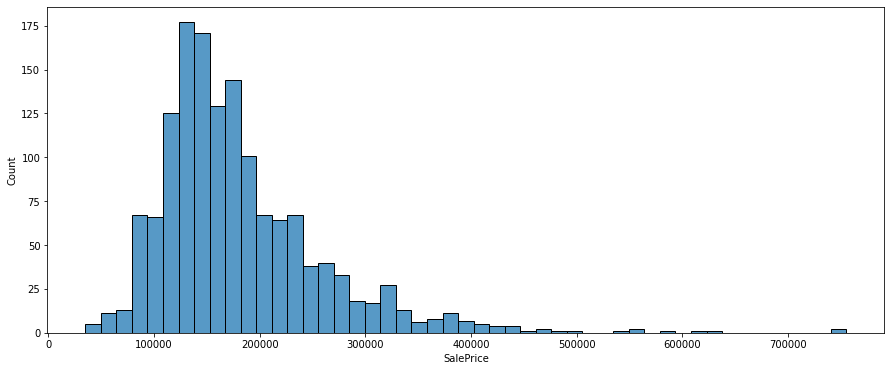

In [ ]:
plt.figure(figsize=(15, 6))
sns.histplot(train_df.SalePrice)

Распределение целевой переменной смещено влево. После удаления из тренировочного датасета выбросов правее 95-квантиля произршло ухудшение качества работы модели.
Особенностей работы с информацией, преобразованной методом Бокса-Кокса не поняла в достаточной степени, потому решила не использовать.

# Анализ признаков

In [ ]:
def plot_data_against_target(features, target, dataframe):
    """Plots a feature given a specific target variable"""
    
    for feature in features:
        f, ax = plt.subplots(figsize=(12, 8))
        if dataframe[feature].dtype == 'object':
            ax = sns.boxplot(x=feature, y=target, data=dataframe, palette='magma')
        elif dataframe[feature].dtype in ['int64', 'float64'] and len(set(dataframe[feature])) < 20:
            ax = sns.violinplot(x=feature, y=target, data=dataframe, palette="Spectral")
        else:
            ax = sns.scatterplot(x=feature, y=target, data=dataframe, palette="crest")
        f.autofmt_xdate()
        plt.show()    
    return f, ax

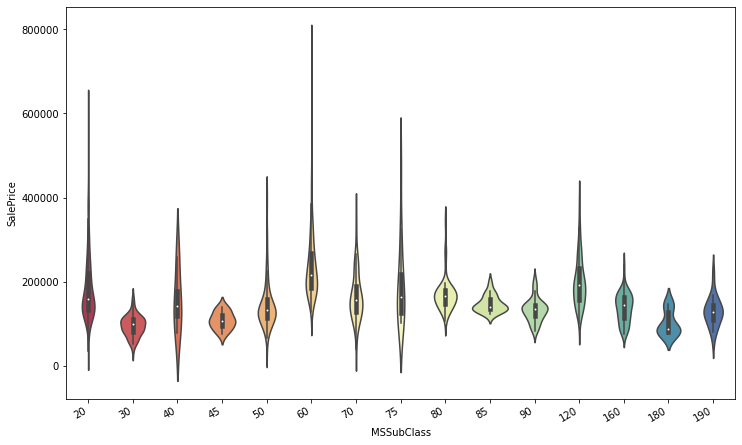

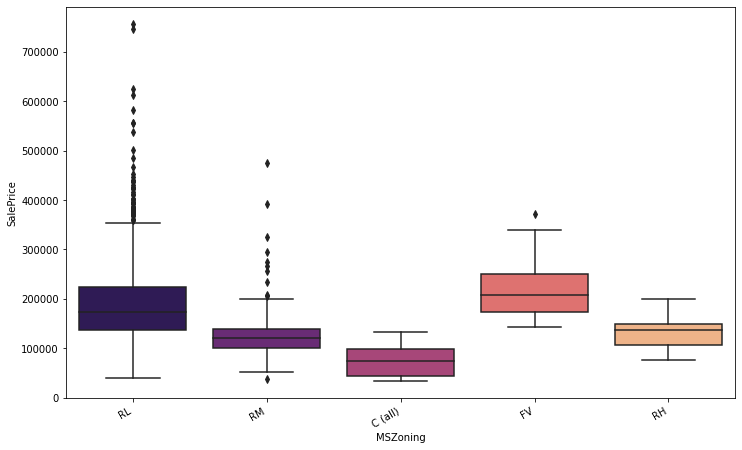

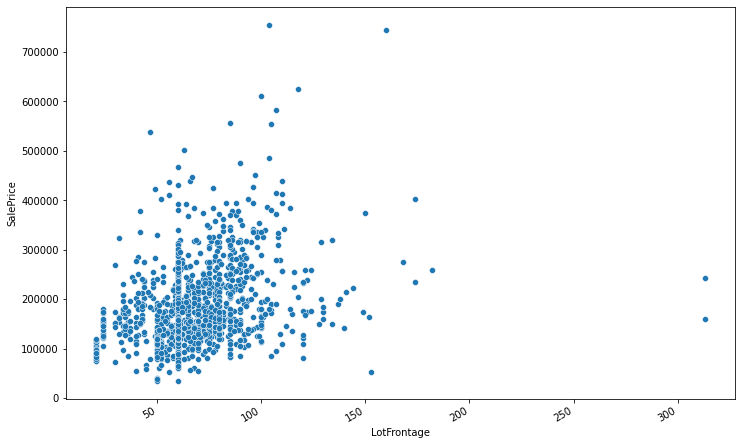

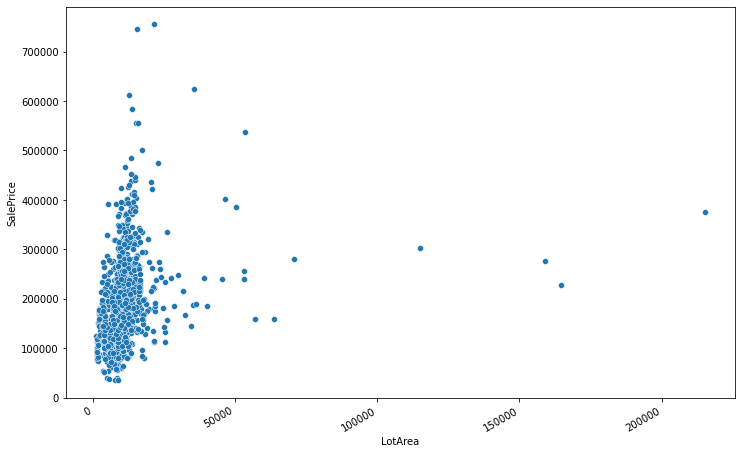

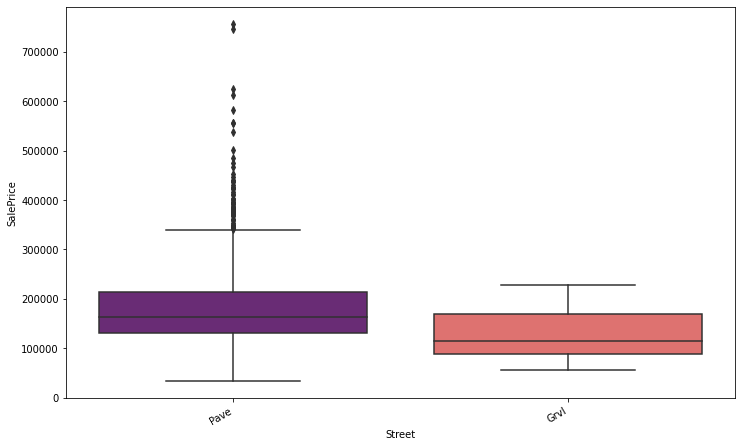

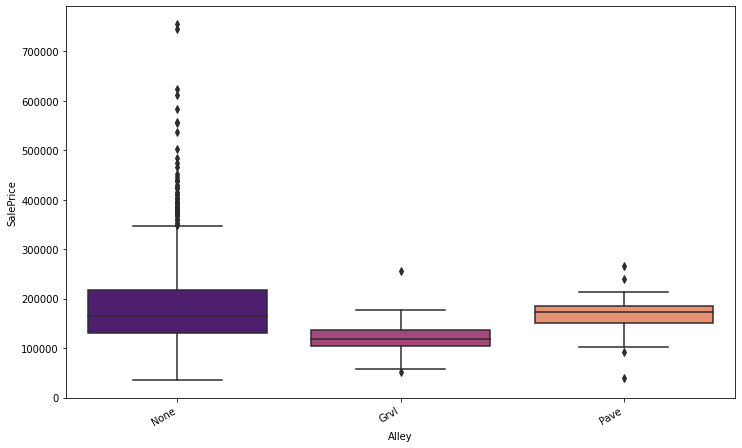

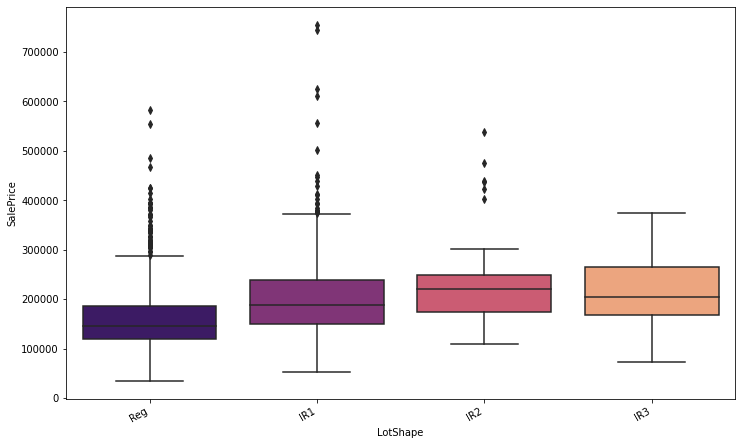

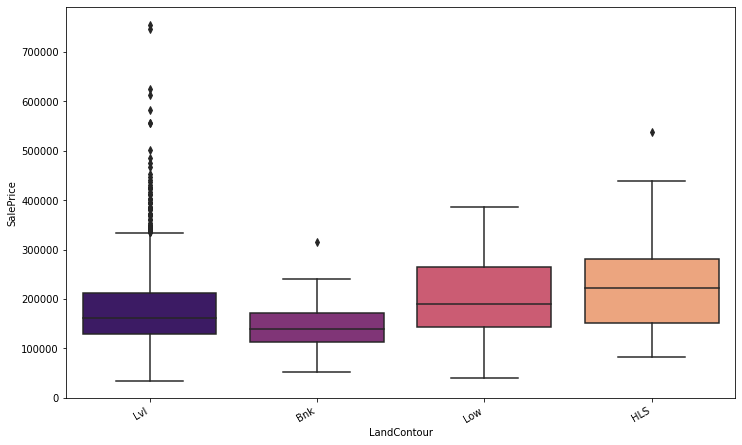

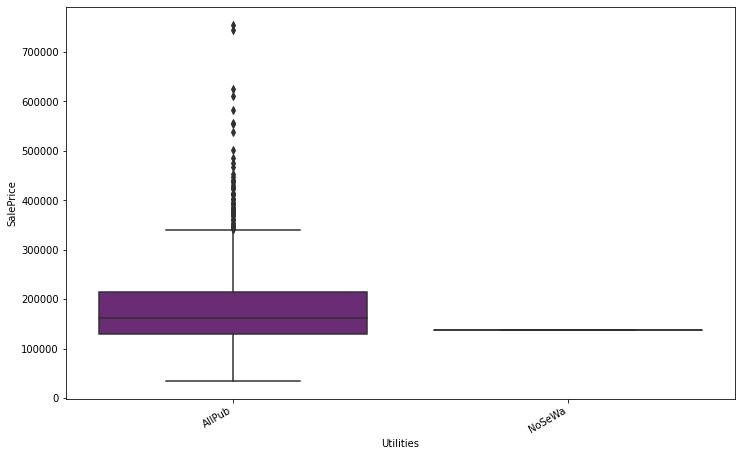

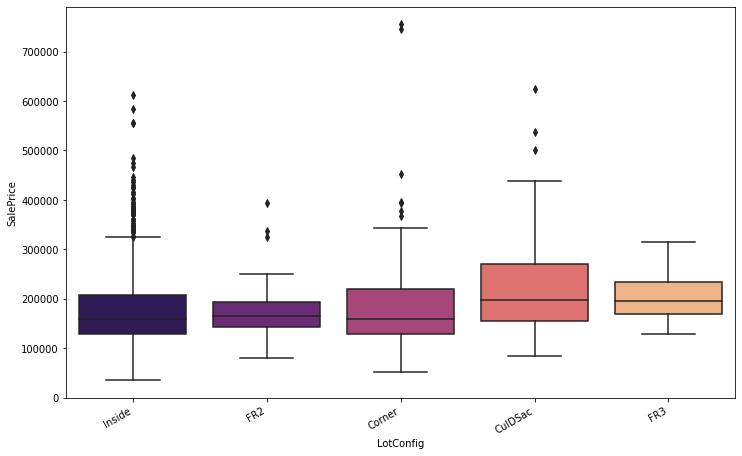

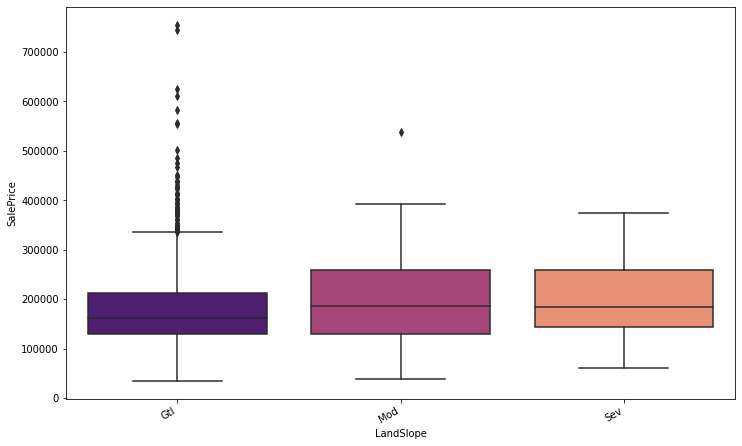

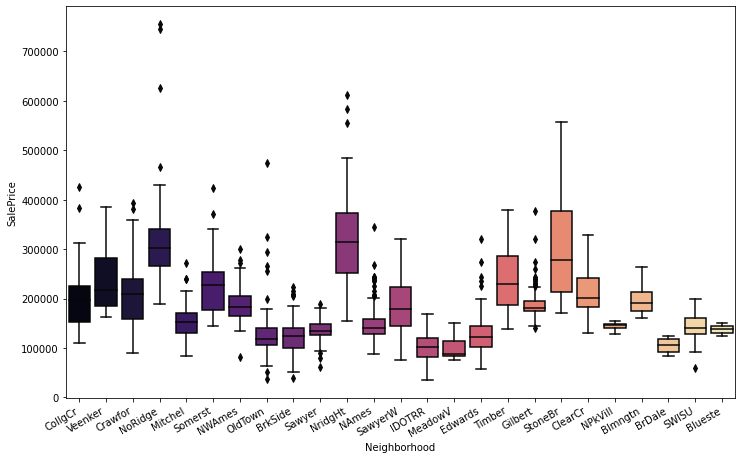

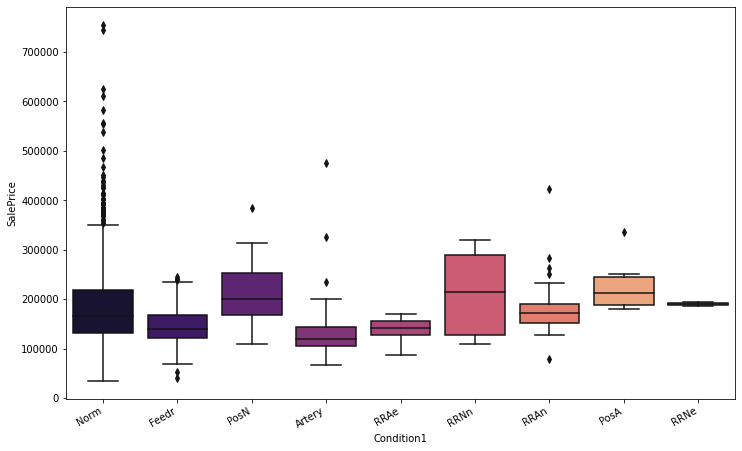

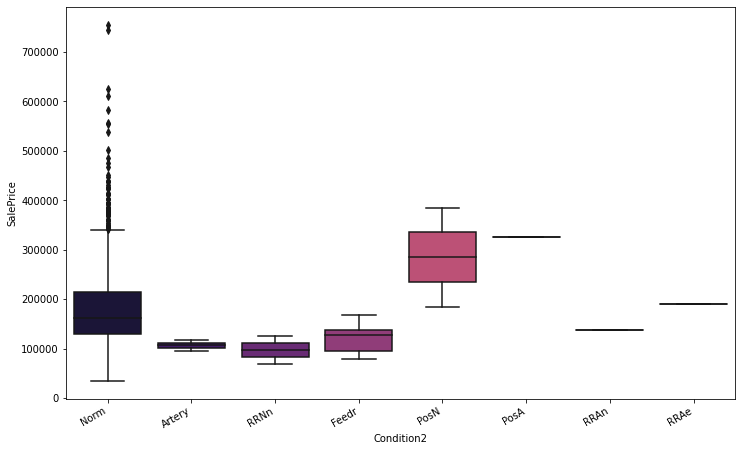

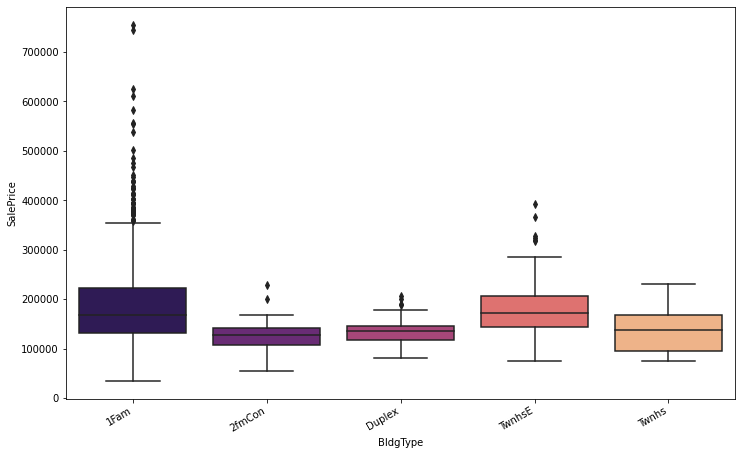

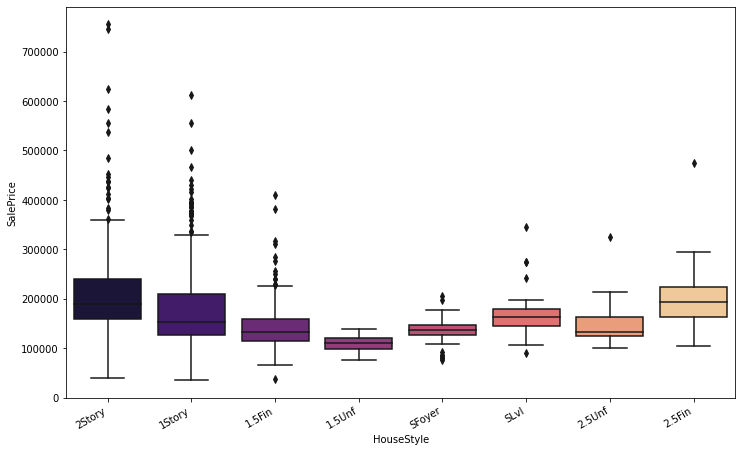

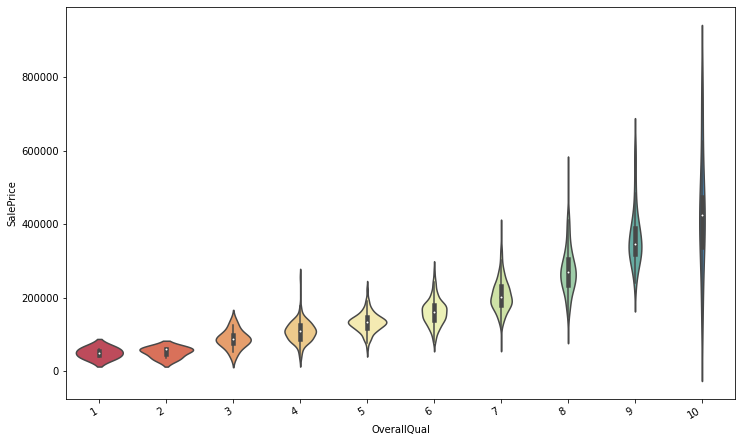

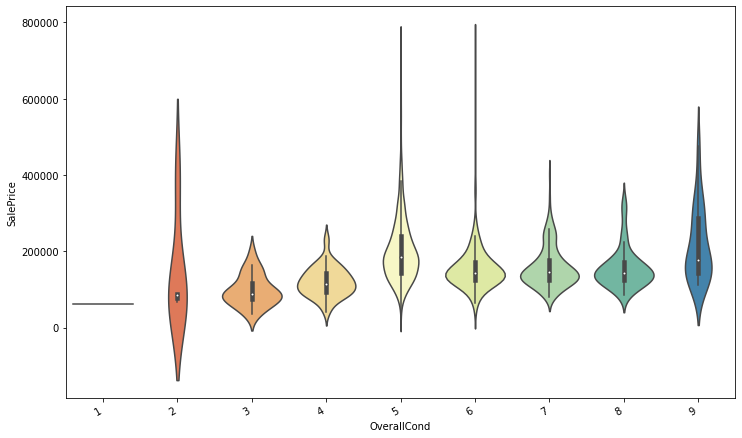

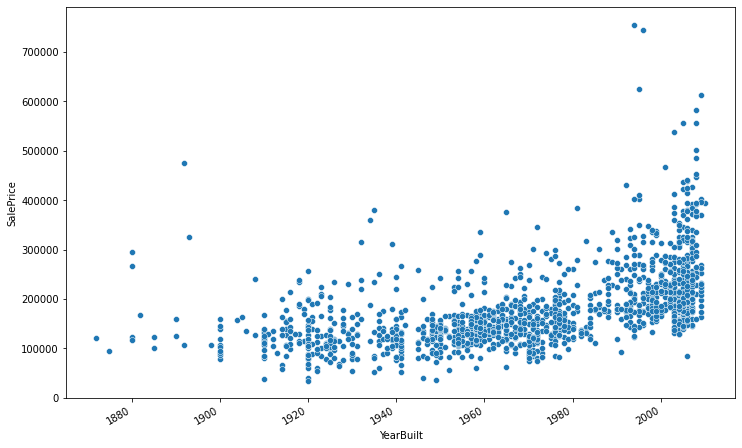

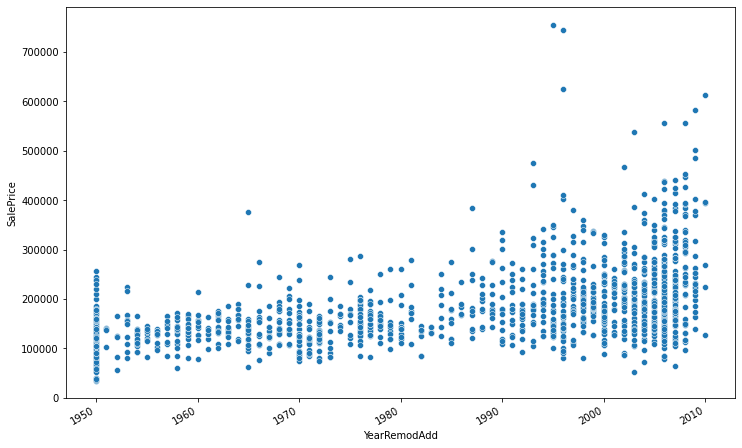

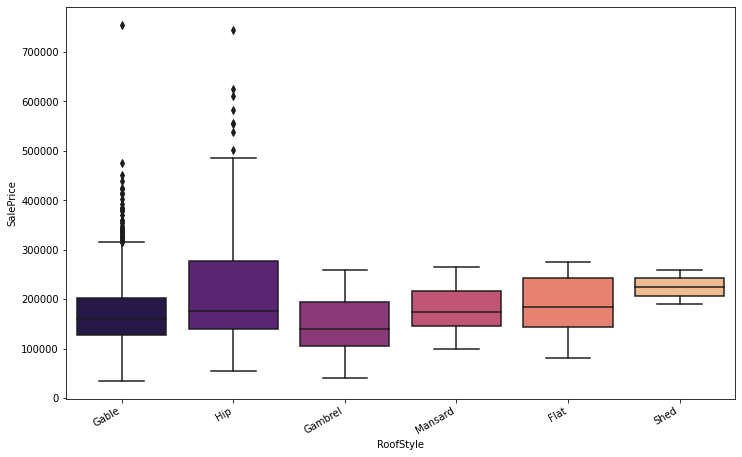

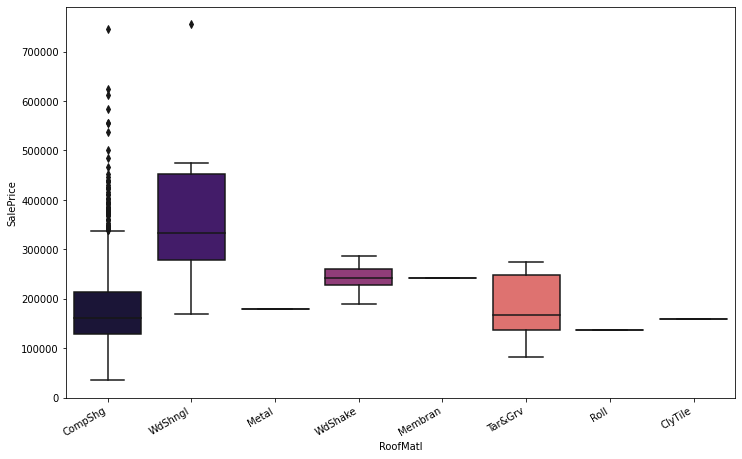

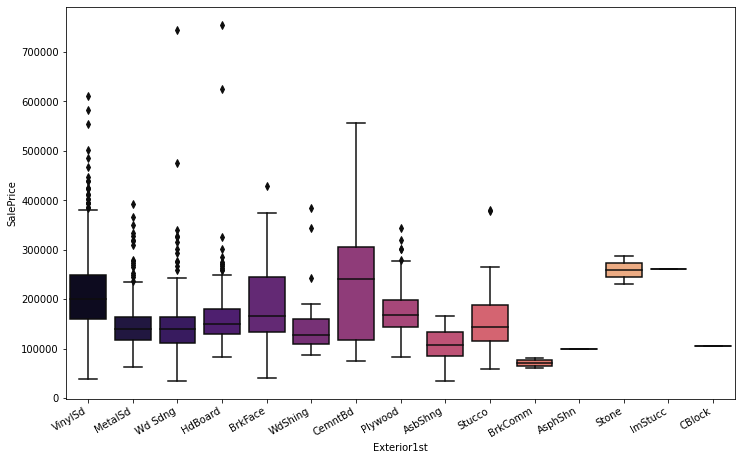

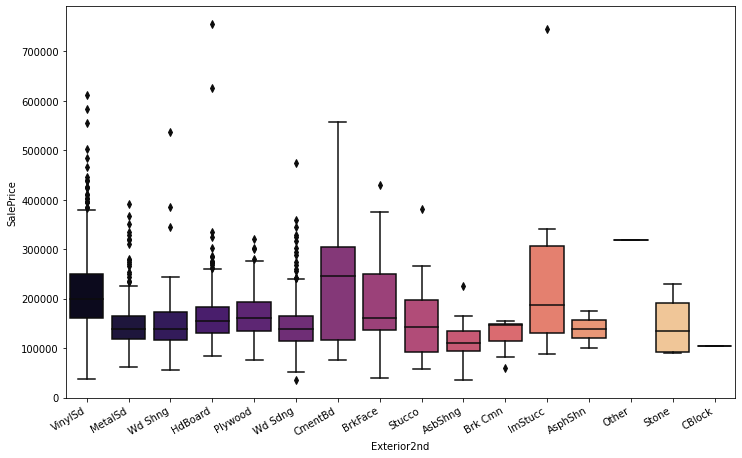

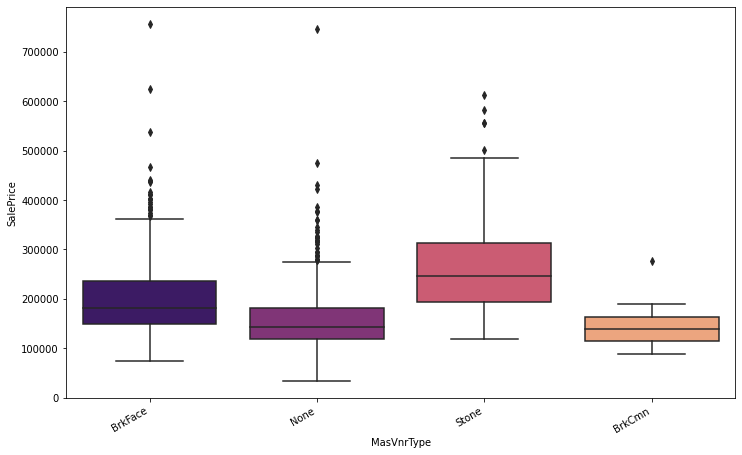

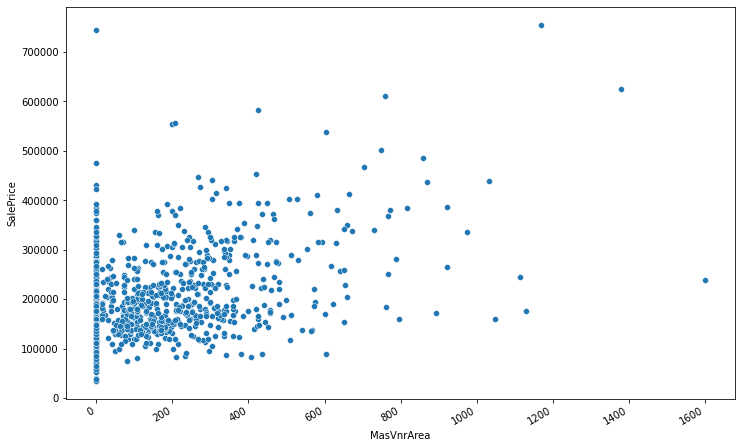

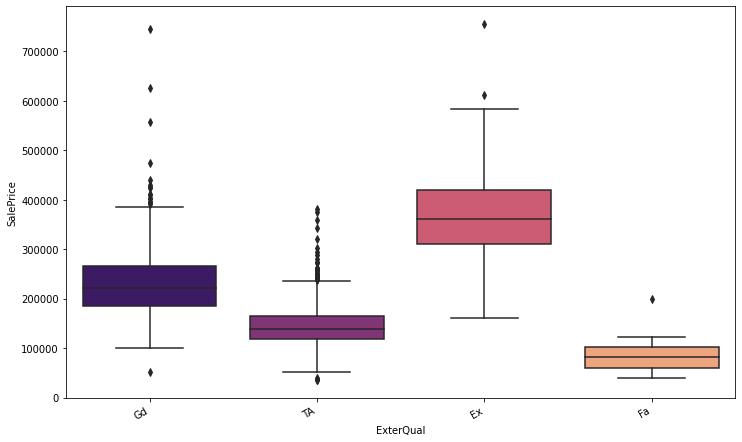

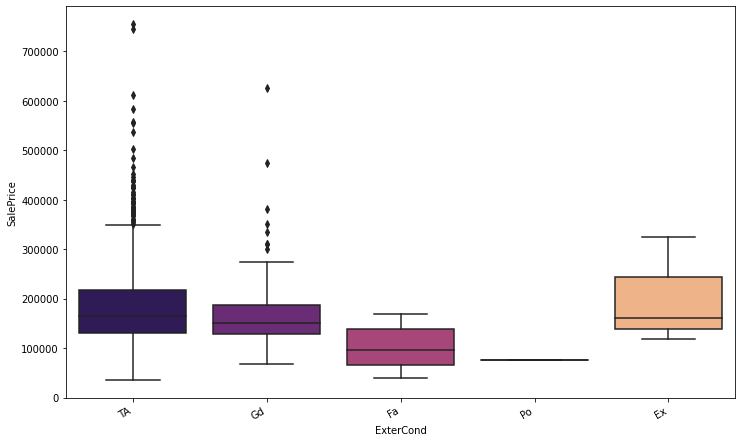

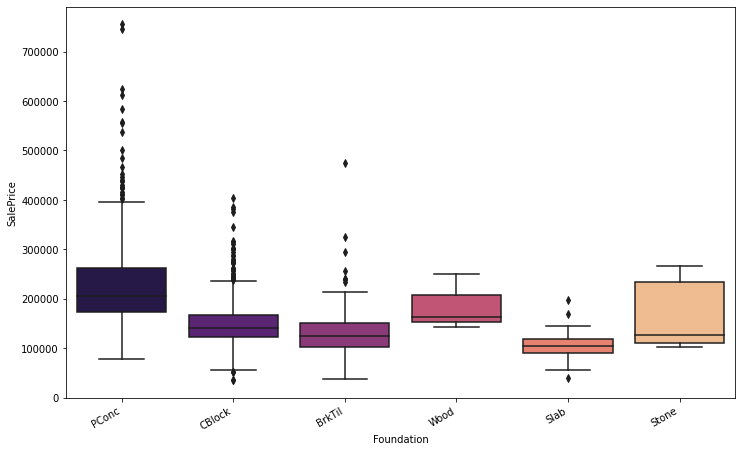

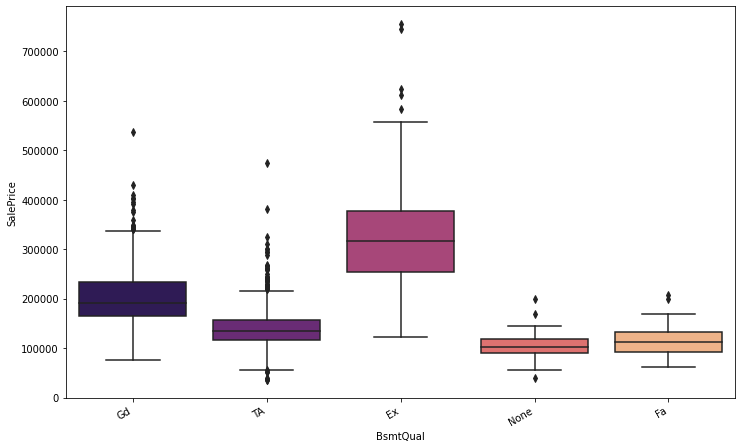

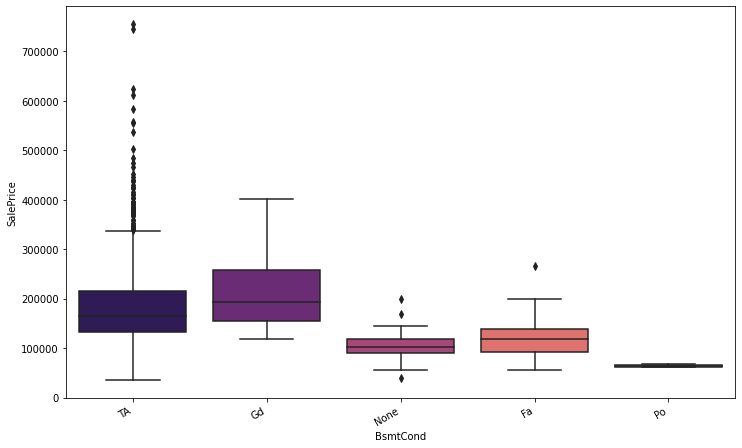

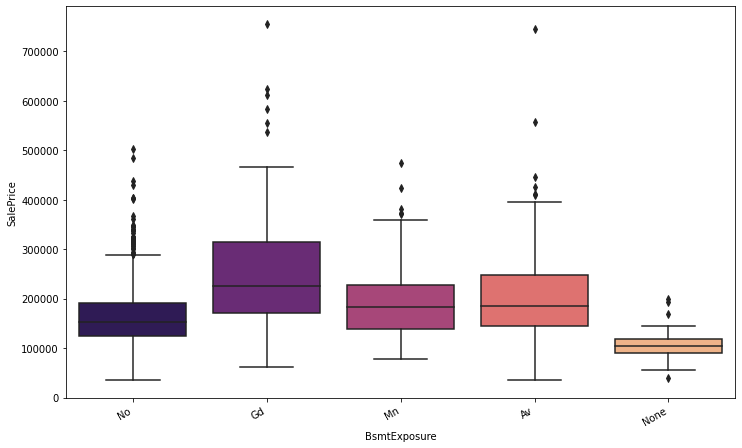

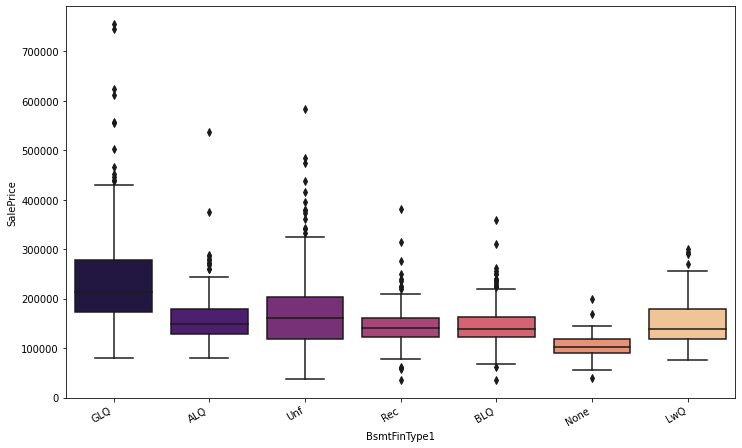

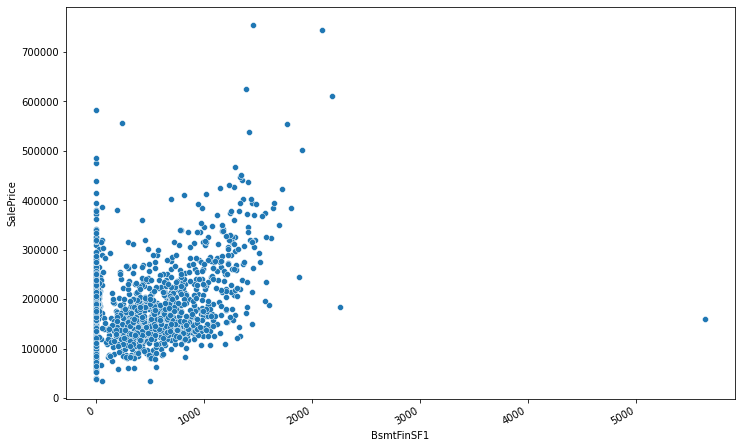

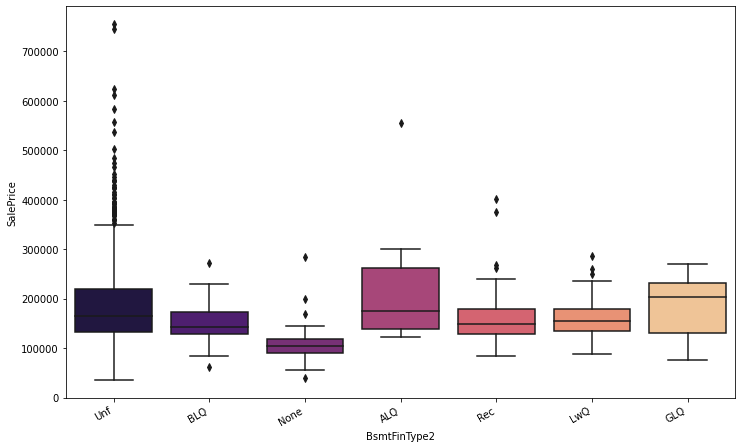

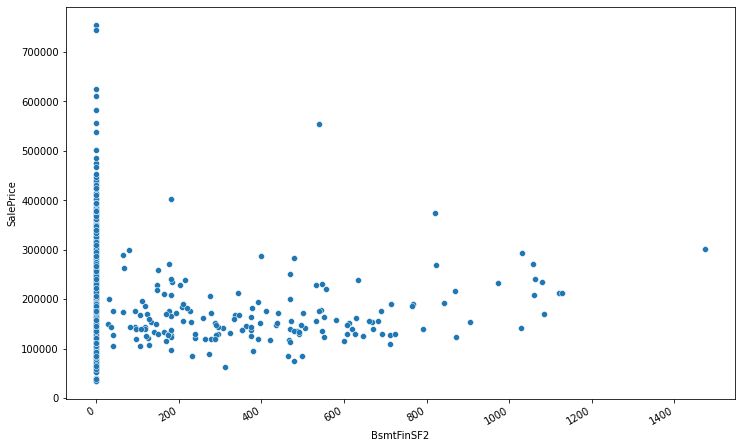

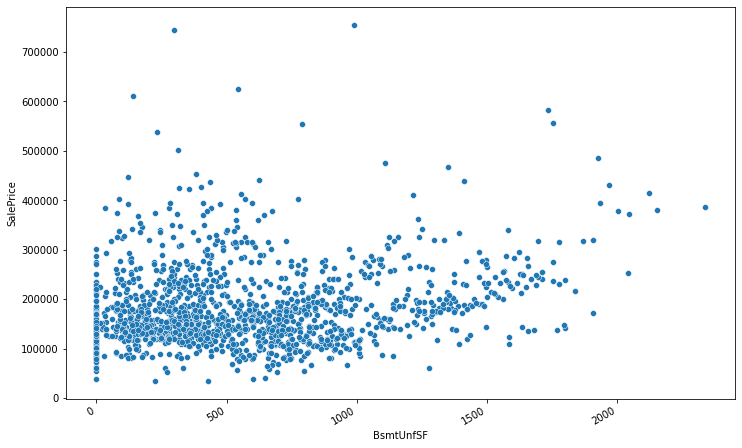

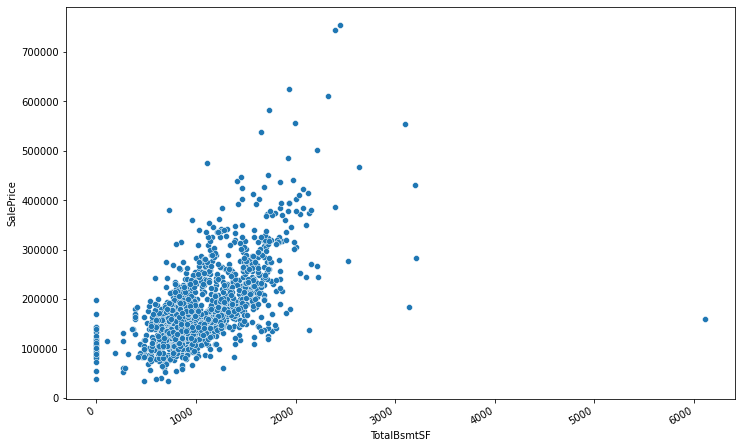

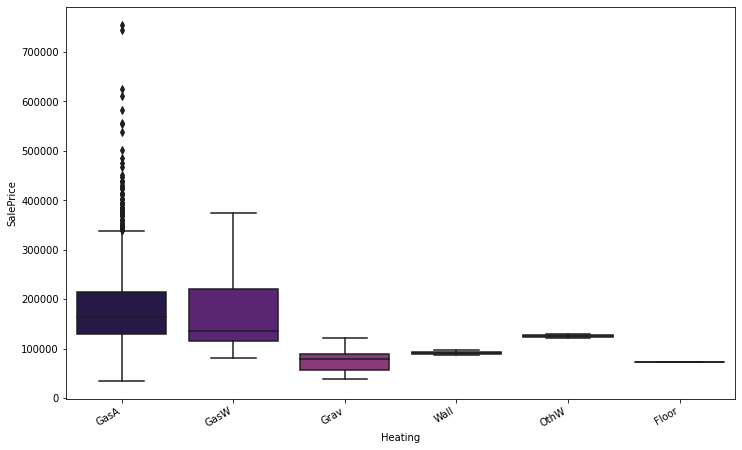

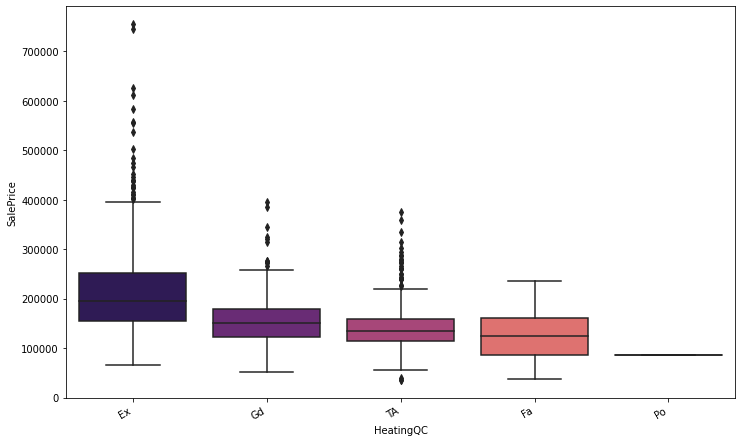

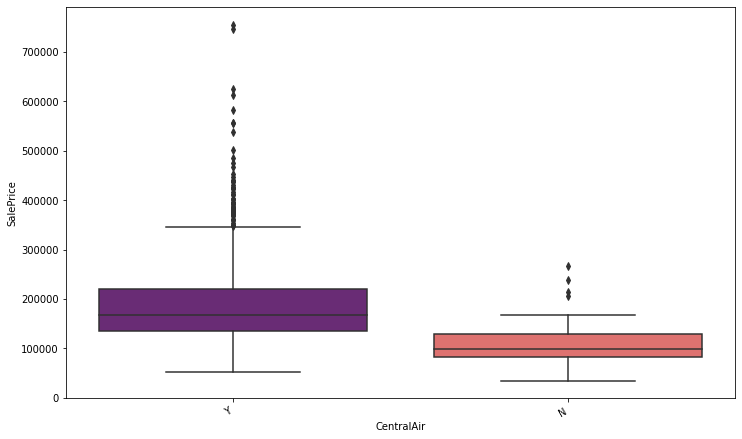

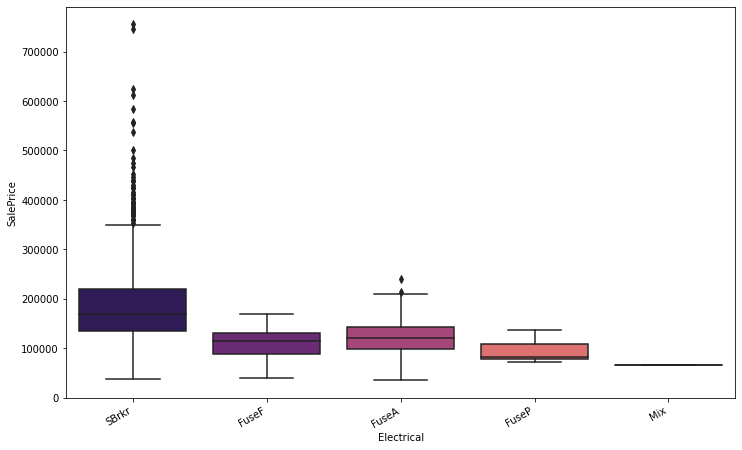

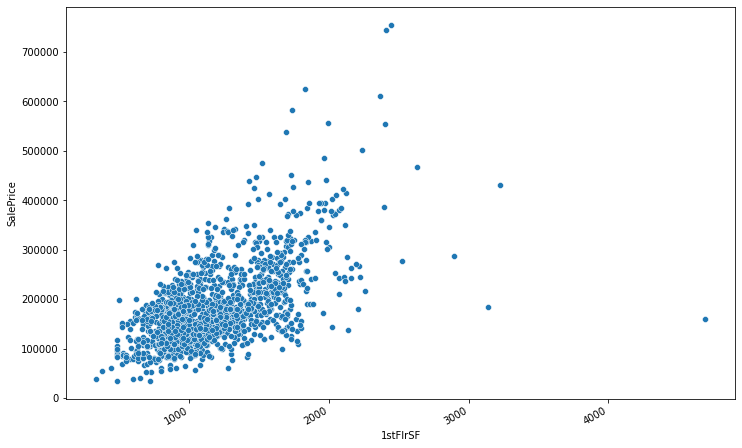

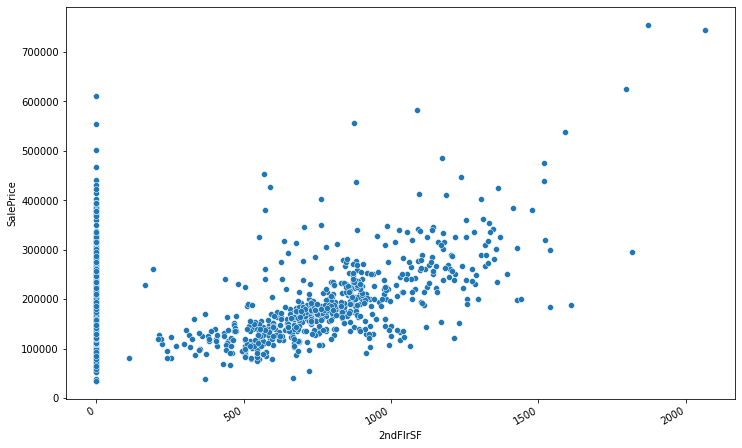

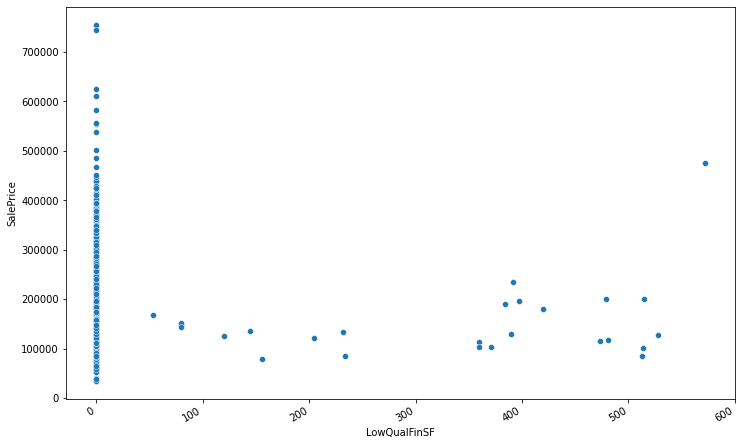

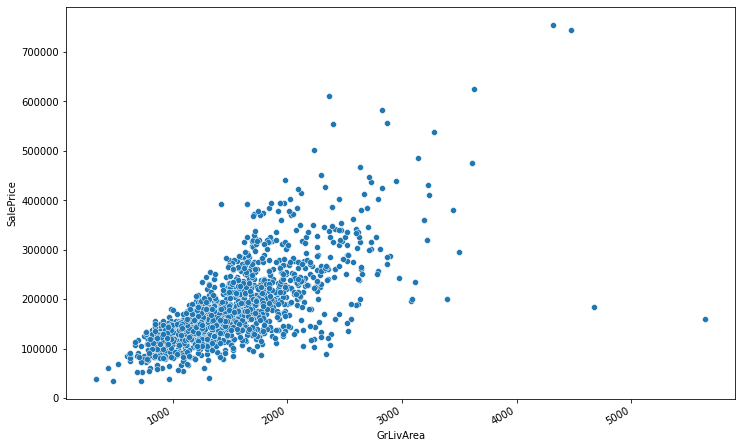

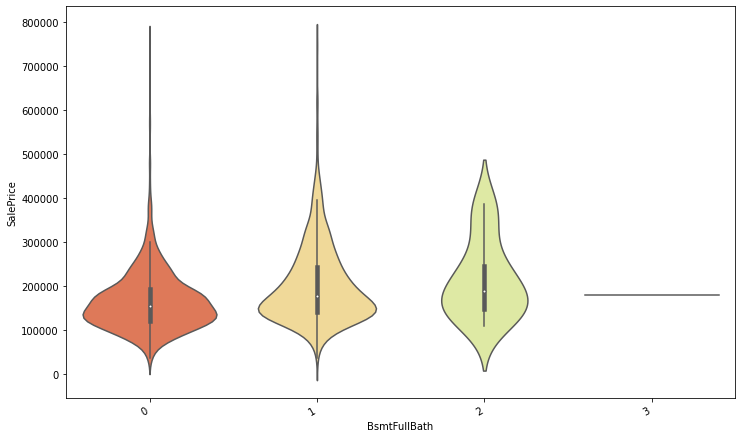

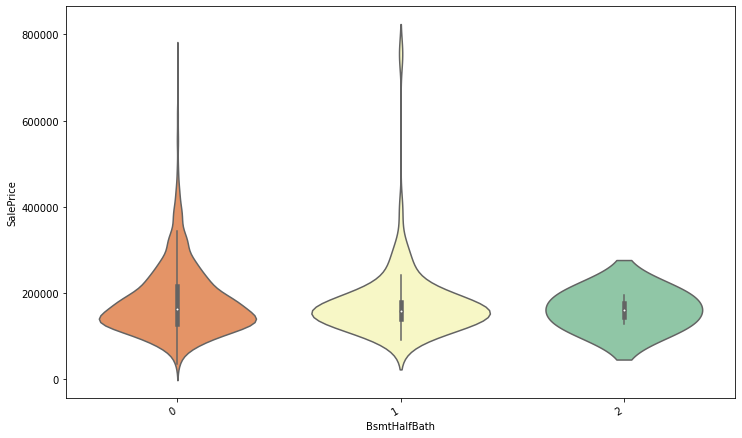

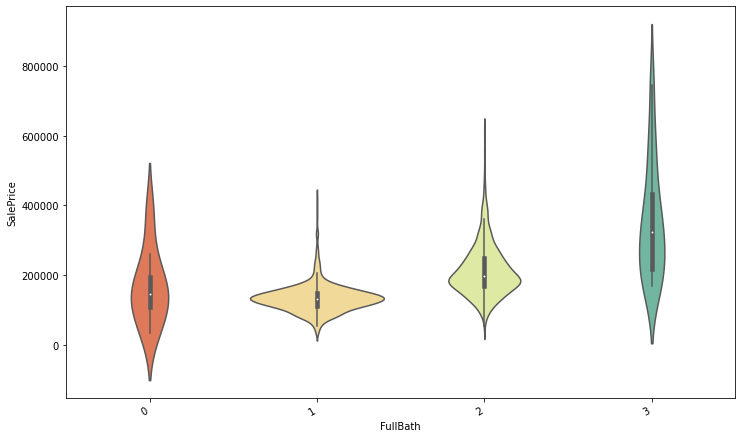

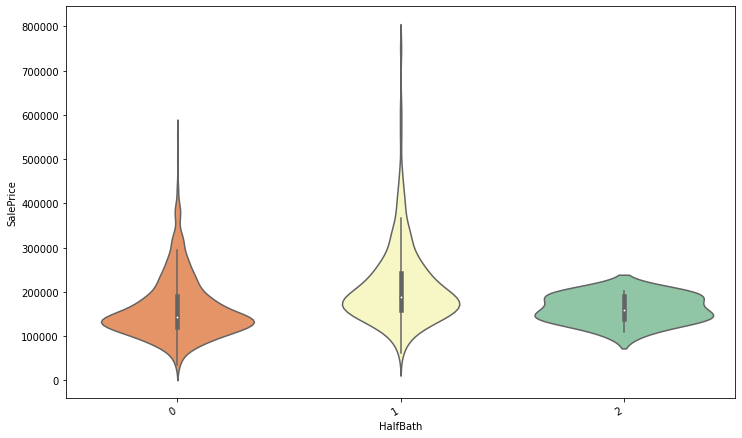

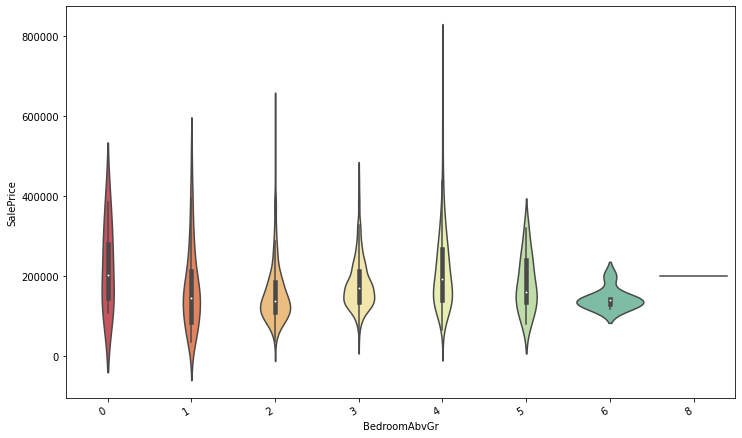

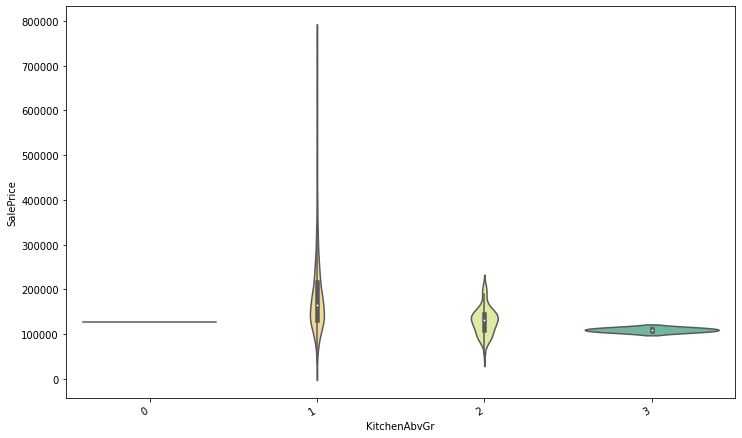

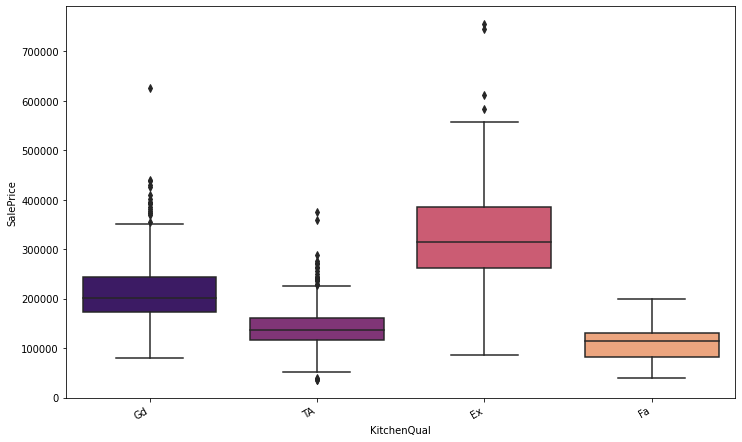

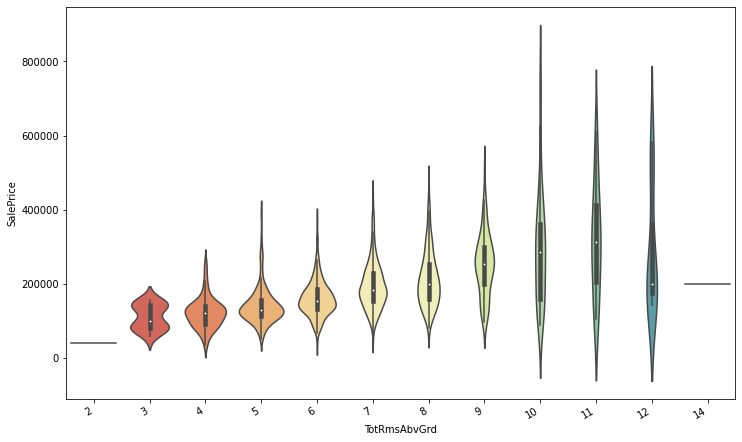

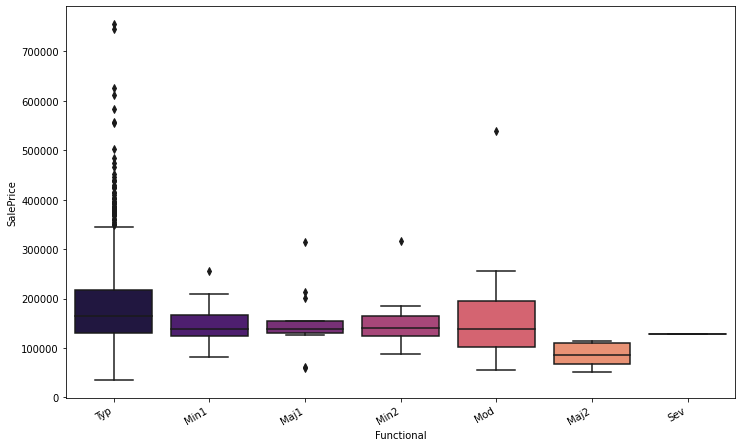

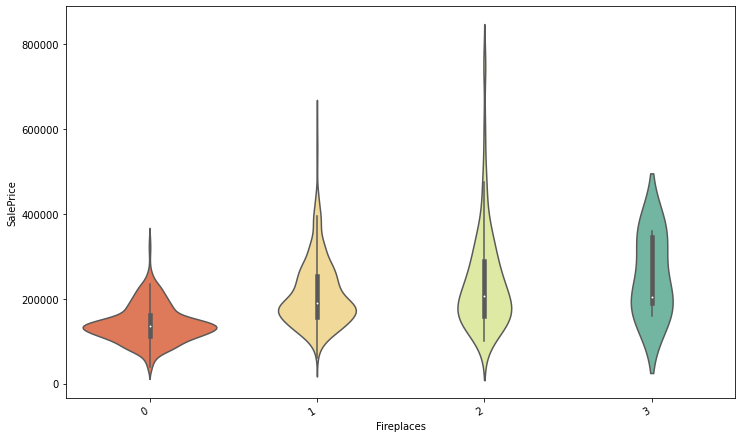

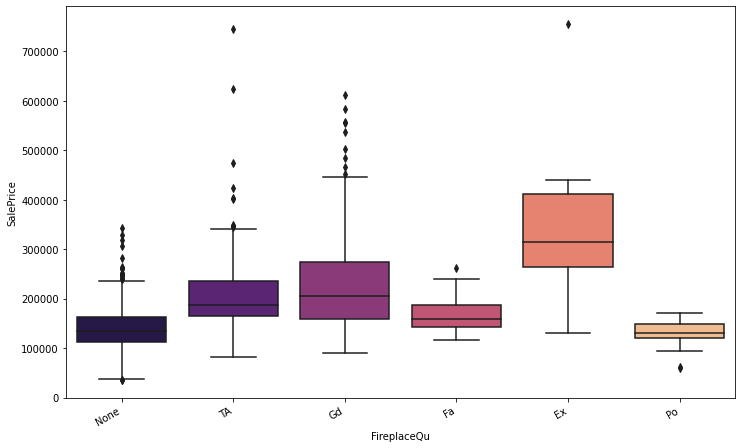

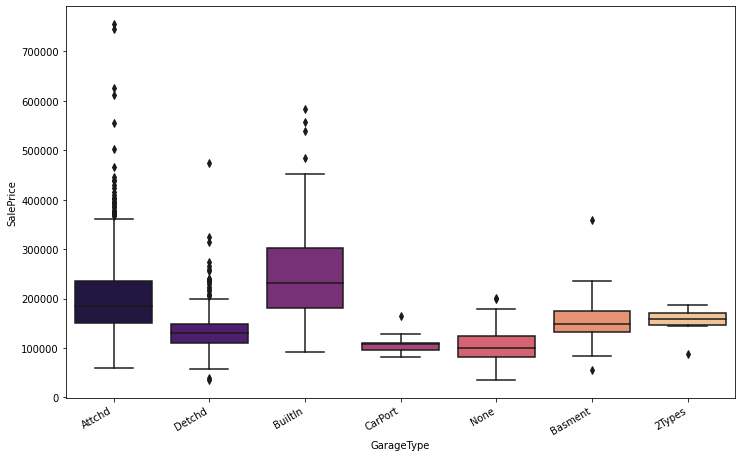

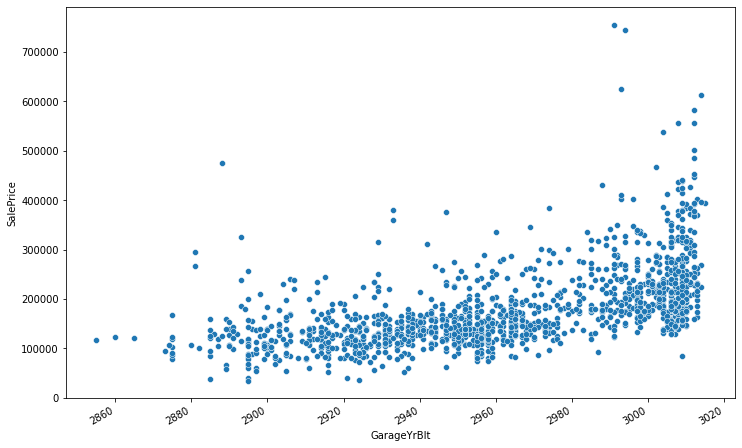

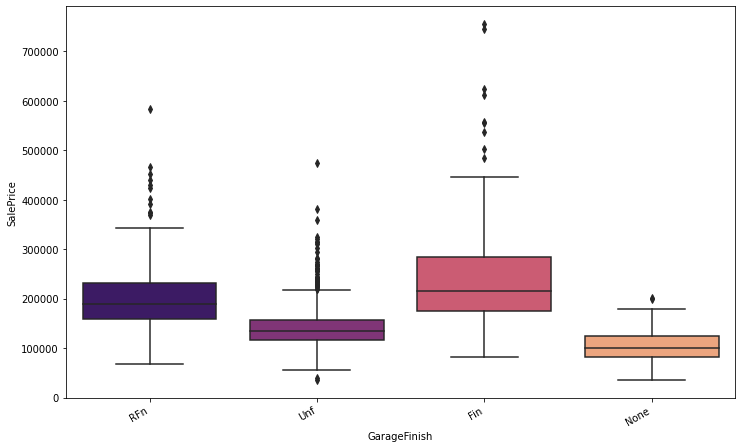

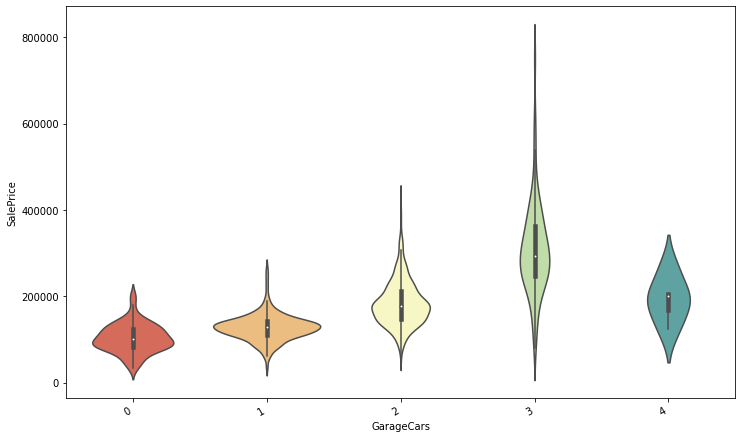

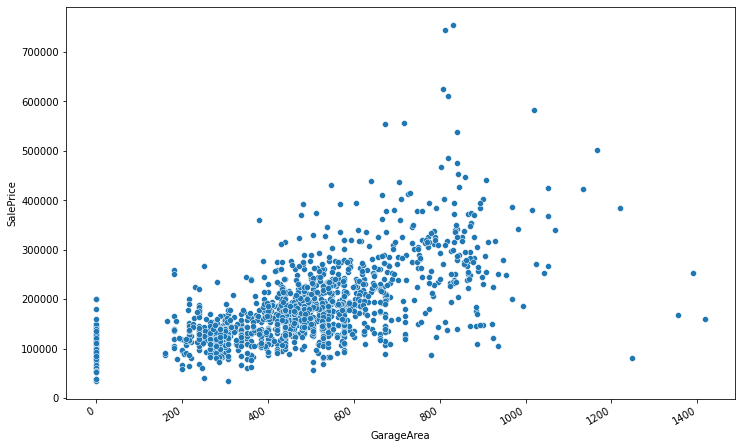

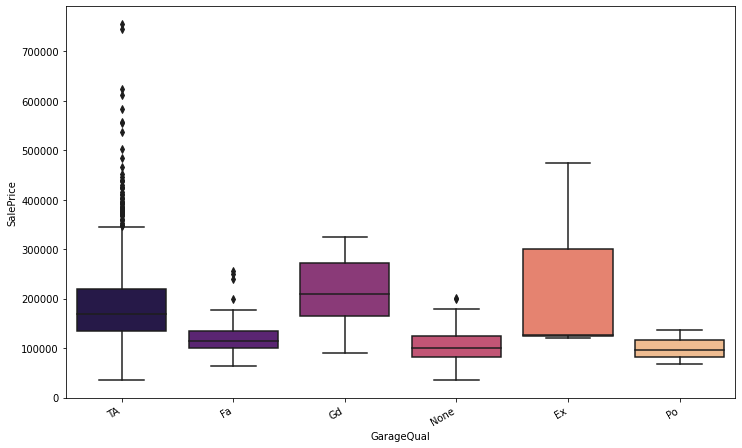

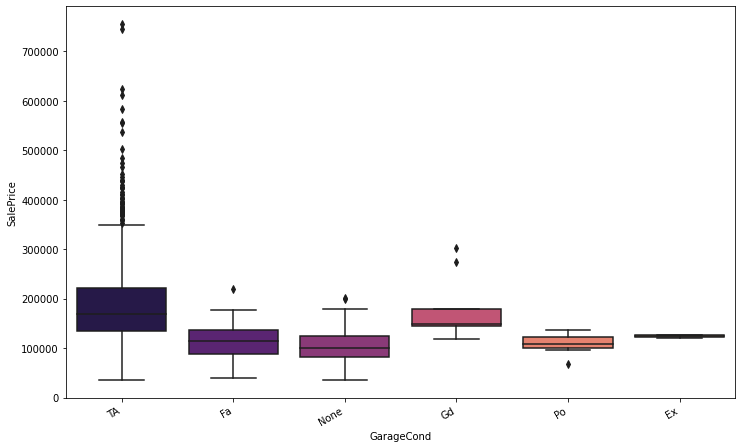

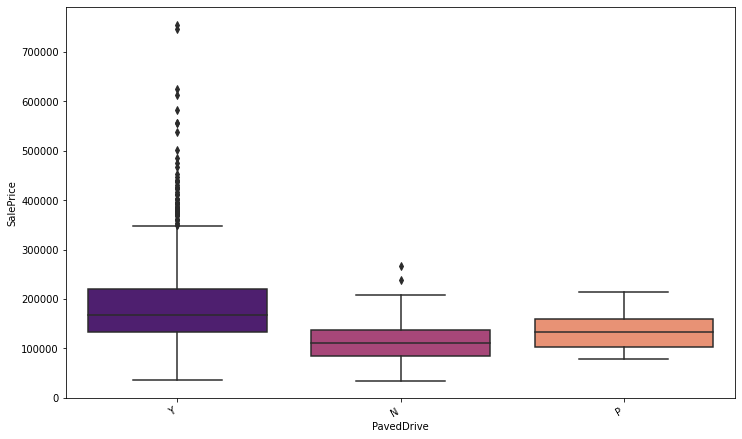

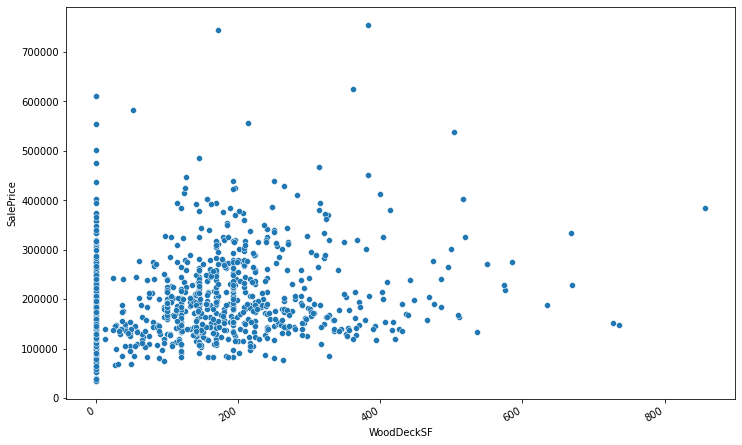

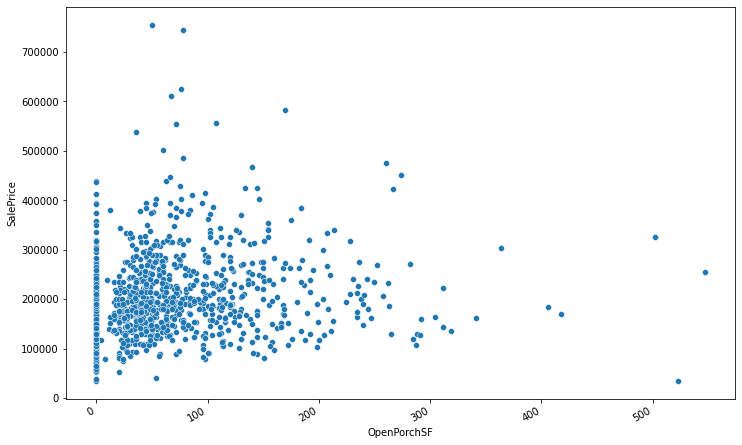

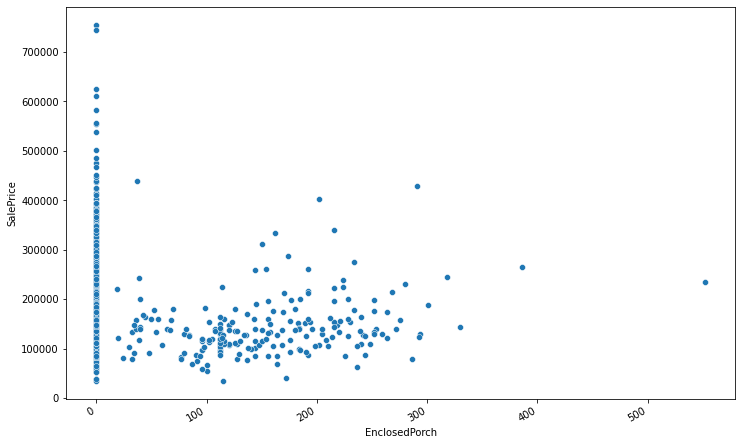

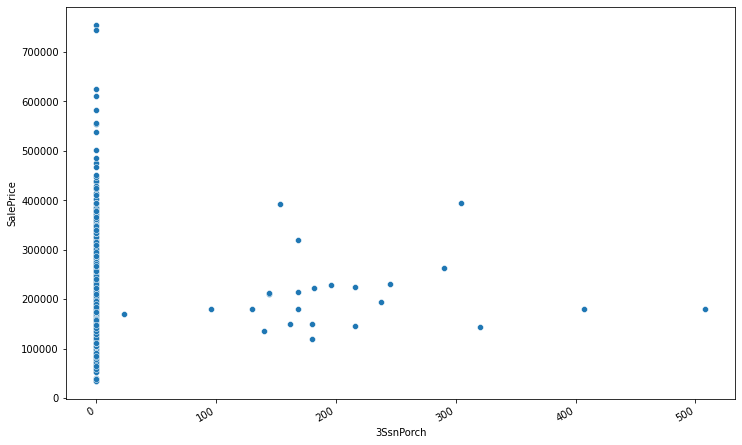

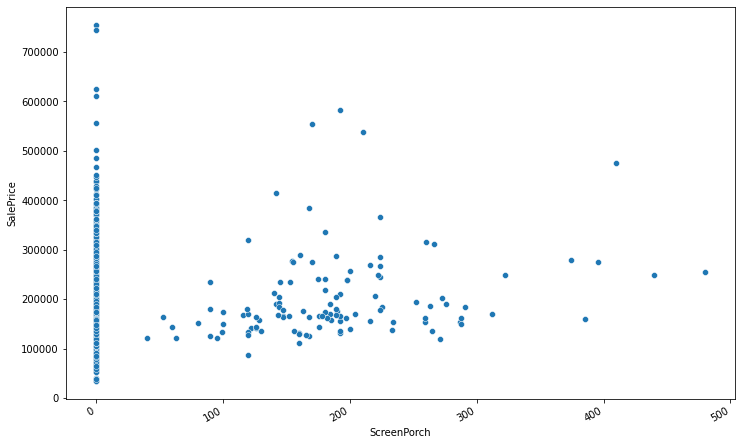

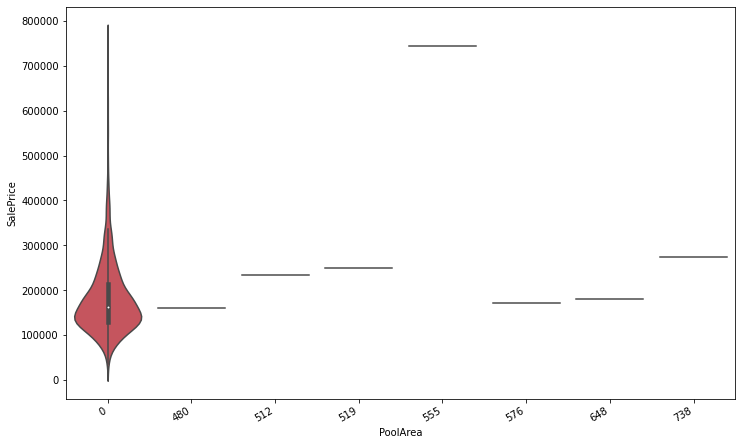

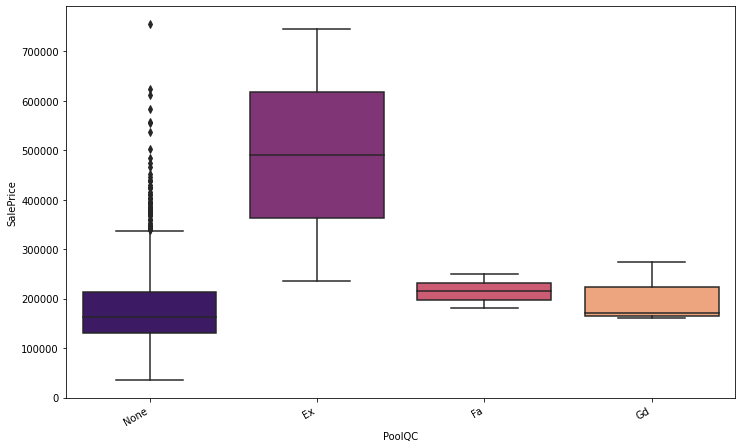

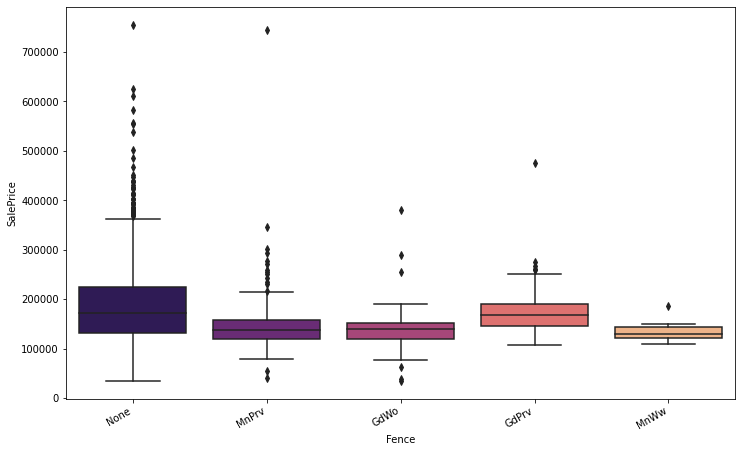

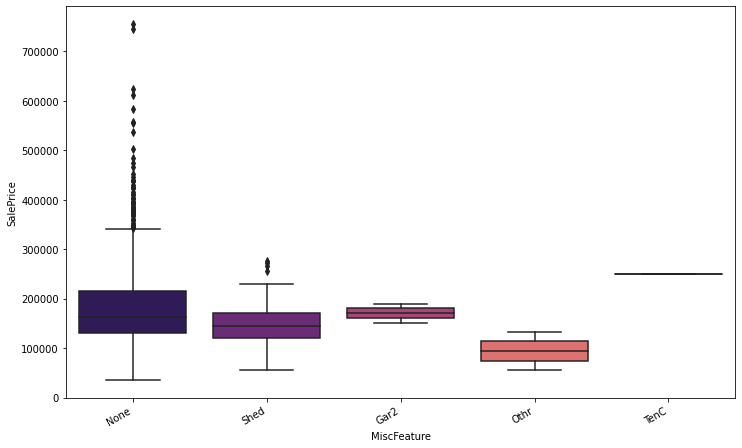

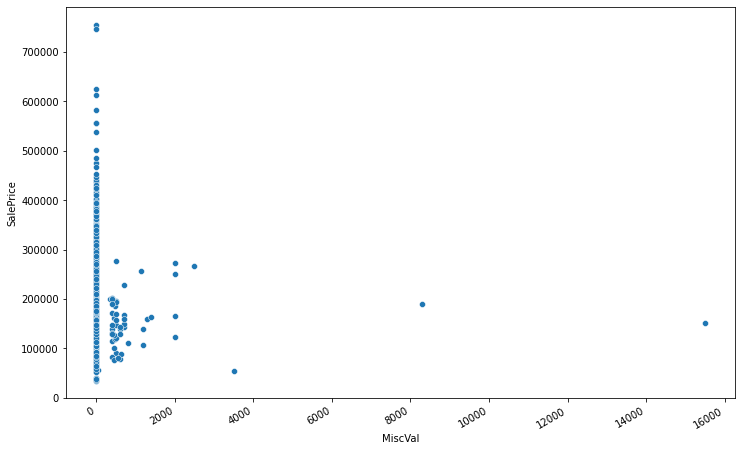

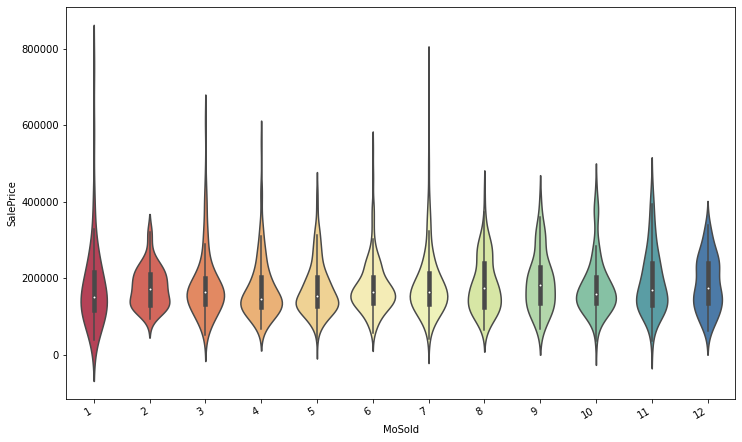

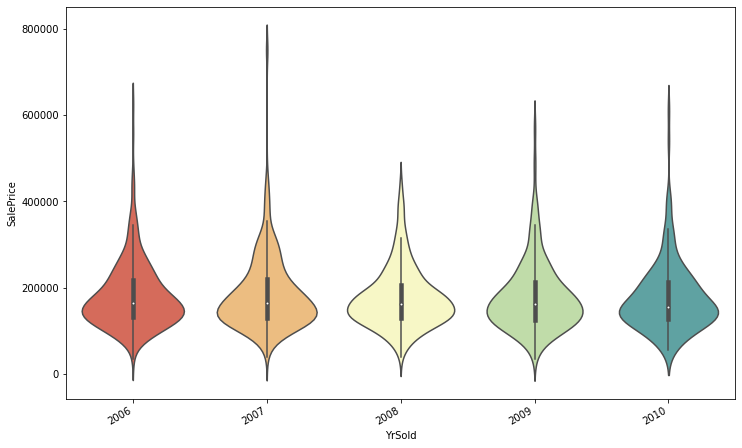

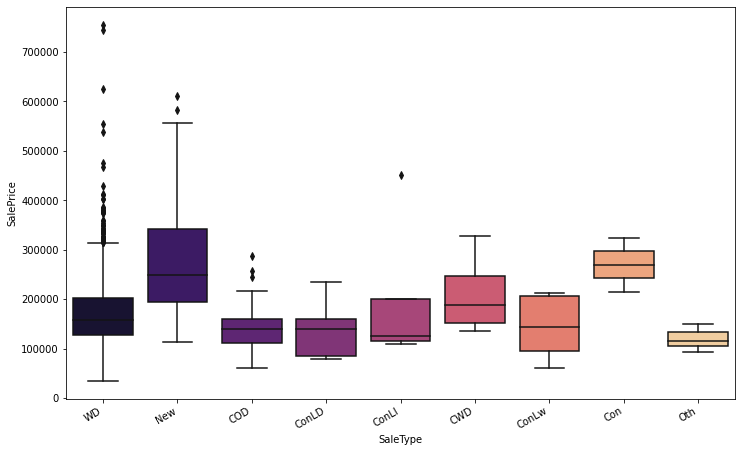

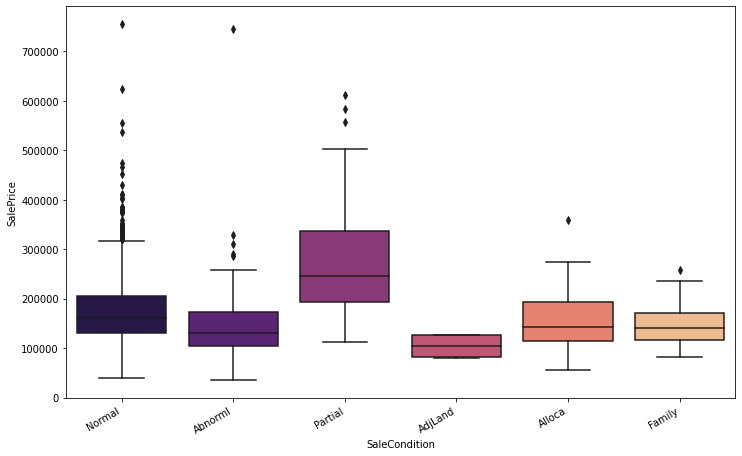

In [ ]:
f, ax = plot_data_against_target(train_df.loc[:, train_df.columns != 'SalePrice'], 'SalePrice', train_df)

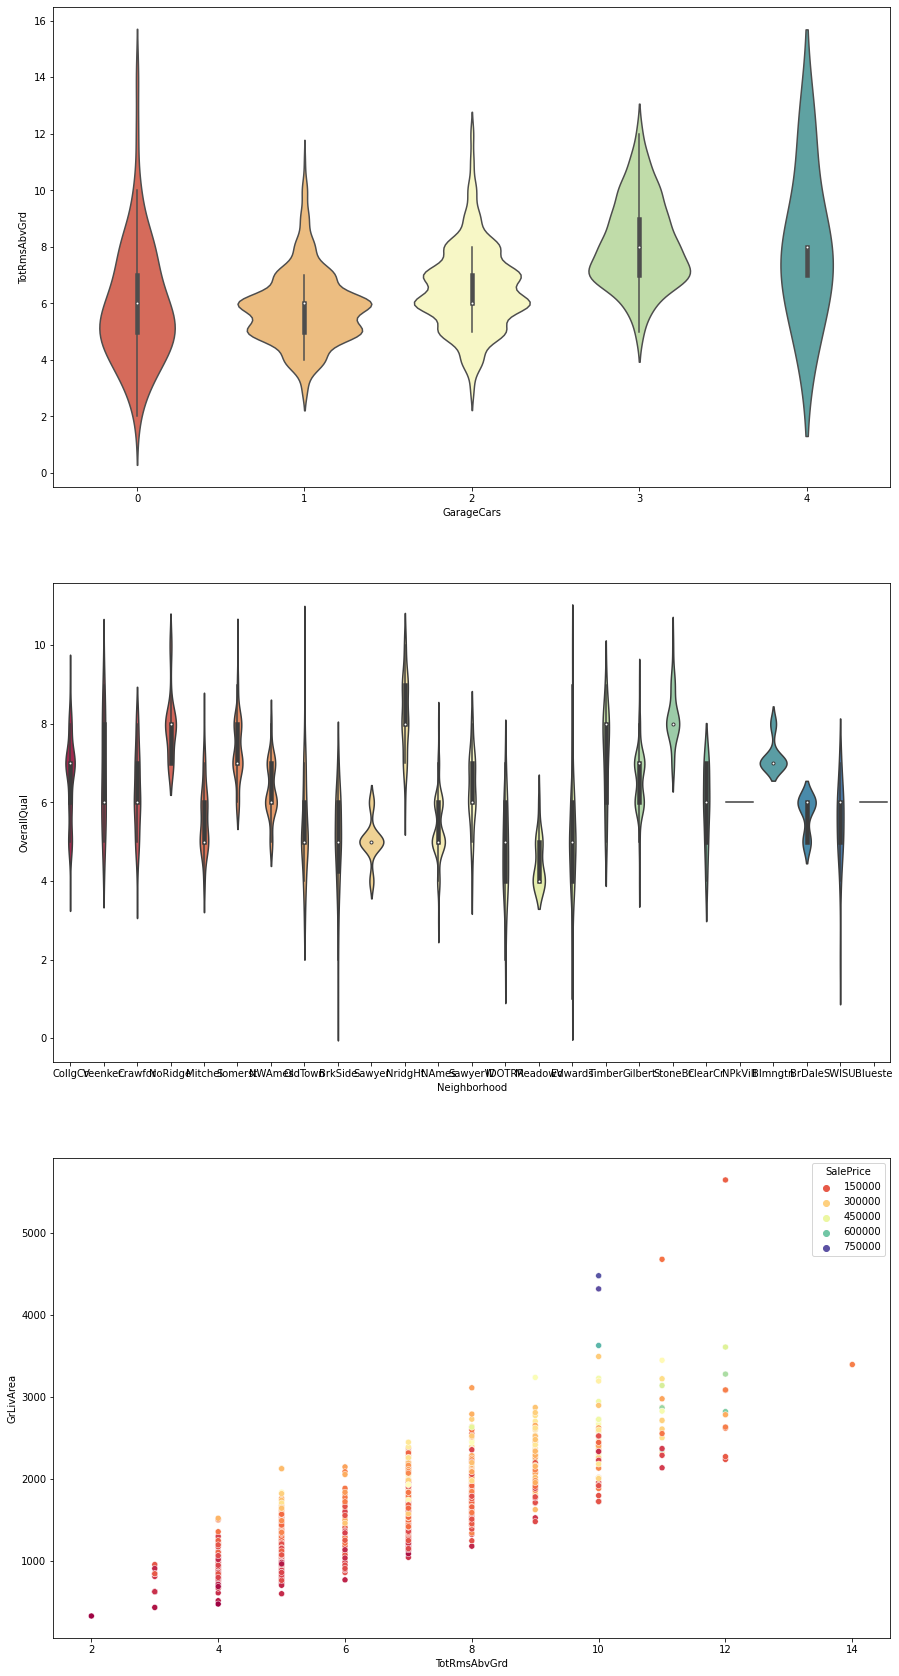

In [ ]:
plt.figure(figsize=(15, 30))

plt.subplot(311)
sns.violinplot(x='GarageCars', y='TotRmsAbvGrd', data=train_df, palette='Spectral')
plt.subplot(312)
sns.violinplot(x='Neighborhood', y='OverallQual', data=train_df, palette='Spectral')
plt.subplot(313)
sns.scatterplot(x='TotRmsAbvGrd', y='GrLivArea', data=train_df, palette='Spectral', hue='SalePrice')

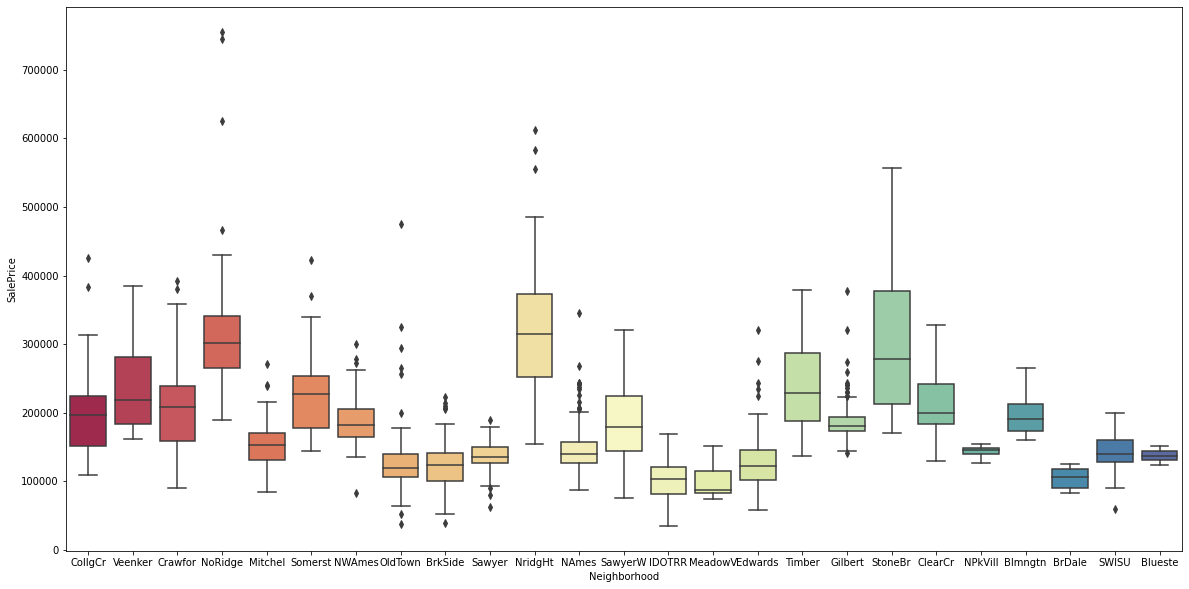

In [ ]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='Neighborhood', y='SalePrice', data=train_df, palette='Spectral')

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(
    data=go.Heatmap(
        z=train_df.SalePrice,
        x=train_df.Neighborhood,
        y=train_df.MSSubClass,
        colorscale='icefire',
        xgap=1,
        ygap=1
    )
)

fig.show()

Исходя из анализа признаков можно предположить, что наибольшее влияние на формирование цены дома оказывают следующие признаки:


1.   Район расположения(дома в более северных районах города, удаленных от университета и аэропорта стоят дороже)
2.   Размер гаража(количество машин, которое может туда поместиться)
3.   Общее "качество" дома (OverallQual)
4.   Дома построенные после 1946 года стоят больше довоенных
5.   Количество комнат в доме прямопропорционально влияет на цену
6.   Наличие в доме камина увеличивает стоимость дома





# Разделение на тестовую и валидационную выборку

In [ ]:
X = train_df.drop(['SalePrice'], axis=1)
y = train_df.SalePrice

In [ ]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=2021)

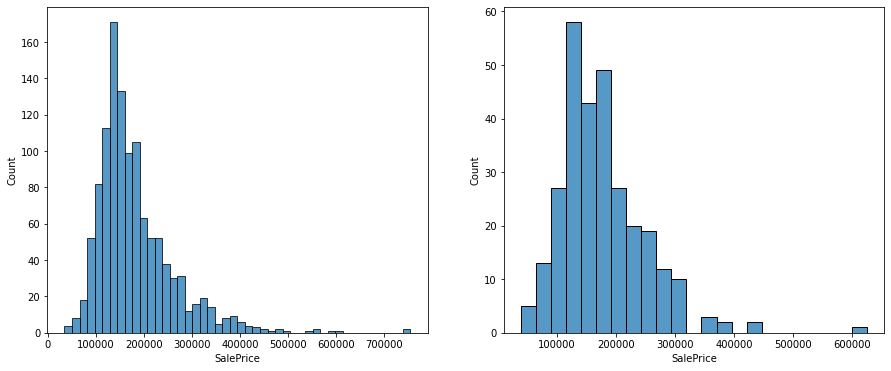

In [ ]:
plt.figure(figsize=(15, 6))

plt.subplot(121)
sns.histplot(train_y)
plt.subplot(122)
sns.histplot(val_y)

Распределение целевой перменной в тренировочной и валидационной выборках в целом совпадает

In [ ]:
categorical_features_indices = list(np.where(X.dtypes != np.float)[0])

train_pool = catboost.Pool(
    train_X,
    label=train_y,
    cat_features=categorical_features_indices
)
val_pool = catboost.Pool(
    val_X,
    label=val_y,
    cat_features=categorical_features_indices
)

# Обучение модели (CatBoost.Regressor)



In [ ]:
catboost_train_dir = 'house_price'

reg = catboost.CatBoostRegressor(
    eval_metric='RMSE',
    od_pval=0.05,
    od_wait=20,
    random_seed=2021,
    train_dir=catboost_train_dir,
    task_type='CPU',
    max_ctr_complexity=4,
    use_best_model=True
)
reg.fit(
    train_pool, 
    eval_set=val_pool,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.047388
0:	learn: 78578.9907337	test: 69621.1305924	best: 69621.1305924 (0)	total: 229ms	remaining: 3m 48s
1:	learn: 76248.7735928	test: 67306.5080977	best: 67306.5080977 (1)	total: 314ms	remaining: 2m 36s
2:	learn: 74114.5752370	test: 65238.7673602	best: 65238.7673602 (2)	total: 348ms	remaining: 1m 55s
3:	learn: 72138.8167472	test: 63285.7079032	best: 63285.7079032 (3)	total: 472ms	remaining: 1m 57s
4:	learn: 70268.3776102	test: 61566.0089280	best: 61566.0089280 (4)	total: 543ms	remaining: 1m 48s
5:	learn: 68445.2366314	test: 59704.7846932	best: 59704.7846932 (5)	total: 636ms	remaining: 1m 45s
6:	learn: 66762.8416694	test: 58242.1395616	best: 58242.1395616 (6)	total: 712ms	remaining: 1m 41s
7:	learn: 65182.8254637	test: 56683.4403240	best: 56683.4403240 (7)	total: 787ms	remaining: 1m 37s
8:	learn: 63756.2737018	test: 55353.1800625	best: 55353.1800625 (8)	total: 854ms	remaining: 1m 33s
9:	learn: 62292.8052181	test: 53956.5056052	best: 53956.5056052 (9)	total: 940m

# Важность признаков и SHAP values

In [ ]:
shap_info = reg.get_feature_importance(
    data=train_pool, 
    type='ShapValues', 
    verbose=10000
)
shap_values = shap_info[:,:-1]
base_values = shap_info[:,-1]

Processing trees...
128/969 trees processed	passed time: 240ms	remaining time: 1.58s
969/969 trees processed	passed time: 1.21s	remaining time: 0us
Processing documents...
128/1160 documents processed	passed time: 31.9ms	remaining time: 257ms
1160/1160 documents processed	passed time: 306ms	remaining time: 0us


In [ ]:
sorted(
    zip(train_X.columns, reg.feature_importances_), 
    key=lambda p: p[1], 
    reverse=True
)

[('OverallQual', 17.672015186102925),
 ('GarageCars', 9.878323508133844),
 ('TotRmsAbvGrd', 5.826513321926439),
 ('FullBath', 4.941473215897029),
 ('ExterQual', 4.489388289528395),
 ('BsmtQual', 4.09661629297829),
 ('KitchenQual', 3.704453625765376),
 ('Fireplaces', 3.6751254761709586),
 ('Neighborhood', 3.517703252896847),
 ('FireplaceQu', 2.9082667661529147),
 ('BsmtExposure', 2.1160212097964664),
 ('BsmtFullBath', 1.8352206559506703),
 ('BedroomAbvGr', 1.7090893776803686),
 ('MSSubClass', 1.3759754434227136),
 ('MasVnrArea', 1.3237443009447636),
 ('KitchenAbvGr', 1.227958618987034),
 ('GarageType', 1.1543780372166523),
 ('HalfBath', 1.1540288707145414),
 ('LotFrontage', 1.0667035956391997),
 ('GarageFinish', 0.962294690217536),
 ('RoofStyle', 0.9309675950269578),
 ('OverallCond', 0.8939781096536195),
 ('MSZoning', 0.8606307542938489),
 ('LandSlope', 0.8280032327926986),
 ('LotShape', 0.7970790780517227),
 ('BsmtFinType1', 0.7660969614719494),
 ('3SsnPorch', 0.739146603113561),
 ('Ye

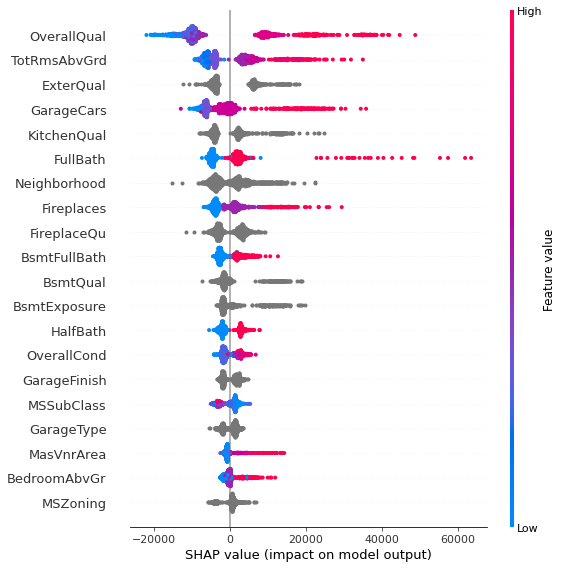

In [ ]:
shap.summary_plot(shap_values, train_X)

Наиболее важными признаками при обучении модели оказались следующие: 

1.   ('OverallQual', 17.672015186102925)
2.   ('GarageCars', 9.878323508133844)
3.   ('TotRmsAbvGrd', 5.826513321926439)
4.   ('FullBath', 4.941473215897029)
5.   ('ExterQual', 4.489388289528395)
6.   ('BsmtQual', 4.09661629297829)
7.   ('KitchenQual', 3.704453625765376)
8.   ('Fireplaces', 3.6751254761709586)
9.   ('Neighborhood', 3.517703252896847)
10.  ('FireplaceQu', 2.9082667661529147)

Подтвердились гипотезы о влияннии общего качества или состояния дома, которое оказалось наиболее важным признаком; о влиянии размера гаража, количества комнат и наличия камина в доме;
Возраст и тип допа не играют ключевой доли;
Важными признаками является наличие удобств: полностью укомплектованной ванной комнаты с совмещенным санузлом и качества кухни и подвала, а вот расположение хоть и имеет достаточный вес, но видимо не является определяющим фактором.

# Submission file

In [ ]:
y_pred = reg.predict(test_X)

submission = pd.DataFrame(index=test_X.index)
submission['SalePrice'] = y_pred
submission.to_csv('final_submission.csv')
submission.head()

NameError: ignored

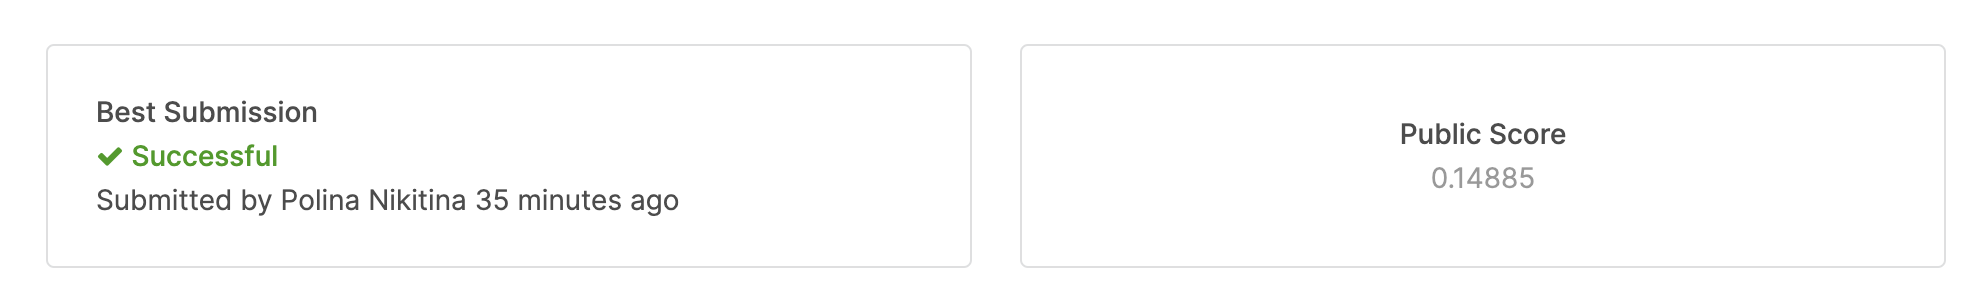